## This Notebook provides a simple example of how a convolutional neural network can be used to classify handwritten letters. Images of lowercase and uppercase letters were obtained from the EMNIST - letter dataset. We will blur the images to varying degrees in order to determine the effect bluriness has on our network's ability to accuraltely classify handwritten letters. 




First, import the dataset and necessary modules.

In [1]:
#install extra-keras-datasets to access the emnist letters dataset
!pip install extra-keras-datasets
from extra_keras_datasets import emnist

#import all modules
import pandas as pd
import numpy as np
import cv2 
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.utils.vis_utils import plot_model
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers 
from tensorflow.keras import regularizers


## Image Preparation

To get the images, we downloaded handwritten letters from the EMNIST - letters dataset. We immediately split the images into a training set and a test set. The test set was duplicated 3 times and images were blurred using a kernel size of 5, 7 or 10. Larger kernel sizes create blurrier images. Multiple kernel sizes were used to determine how blurring affects the accuracy of our network classification. 

The first 30 images of each training set were printed for visual confirmation of blurriness. The images were then reshaped and the RGB codes were normalized so the size of each image was 28 x 28 x 1 (the size needed for input into the neural network). Lastly, one hot encoding was performed to convert category names to numbers.

In [2]:
#import dataset of letters directly as train and test data
(image_train, label_train), (image_test, label_test) = emnist.load_data(type='letters')


INFO:root:Loading dataset = emnist


743915520/743900280 [==============================] - 46s 0us/step


In [3]:
#create blurry images with various kernel sizes 
blurry_image_train_5 = [cv2.blur(image_train[i], (5, 5)) for i in range(len(image_train))]
blurry_image_train_7 = [cv2.blur(image_train[i], (7, 7)) for i in range(len(image_train))]
blurry_image_train_10 = [cv2.blur(image_train[i], (10, 10)) for i in range(len(image_train))]

blurry_image_test_5 = [cv2.blur(image_test[i], (5, 5)) for i in range(len(image_test))]
blurry_image_test_7 = [cv2.blur(image_test[i], (7, 7)) for i in range(len(image_test))]
blurry_image_test_10 = [cv2.blur(image_test[i], (10, 10)) for i in range(len(image_test))]


In [4]:
#check the shapes of our variables
print(image_train.shape)
print(label_train.shape)
print(image_test.shape)
print(label_test.shape)

#check that labels are accurate
print(np.unique(label_test))

(124800, 28, 28)
(124800,)
(20800, 28, 28)
(20800,)
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26]


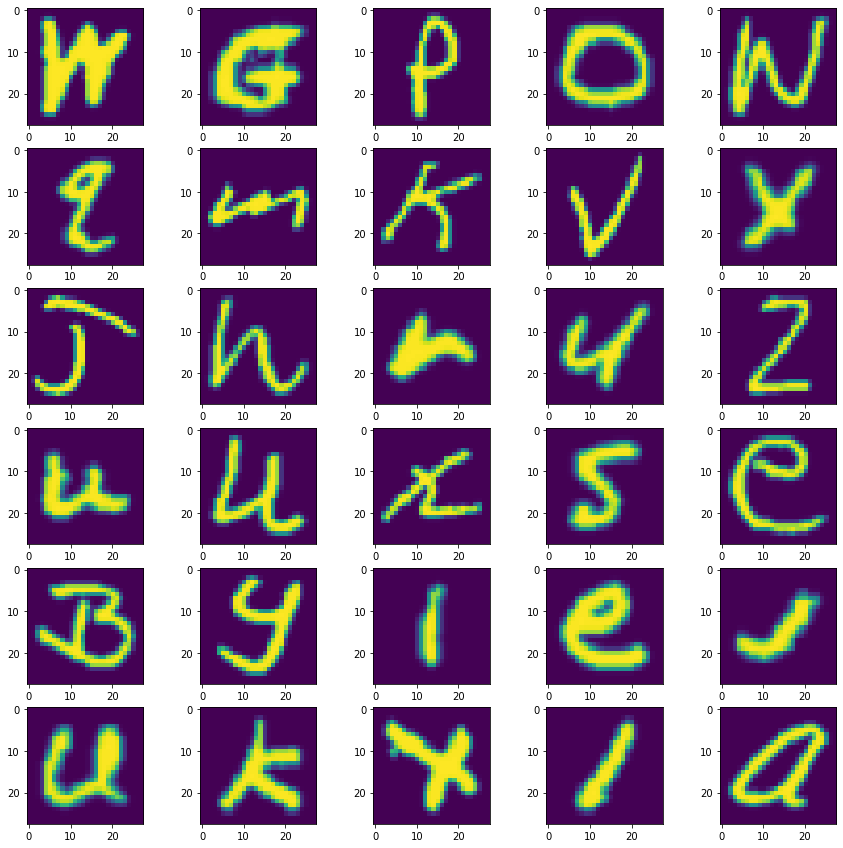

In [5]:
#print the first 30 images to make sure they're readable
f, axs = plt.subplots(6,5,figsize=(15,15))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.imshow(image_train[i])

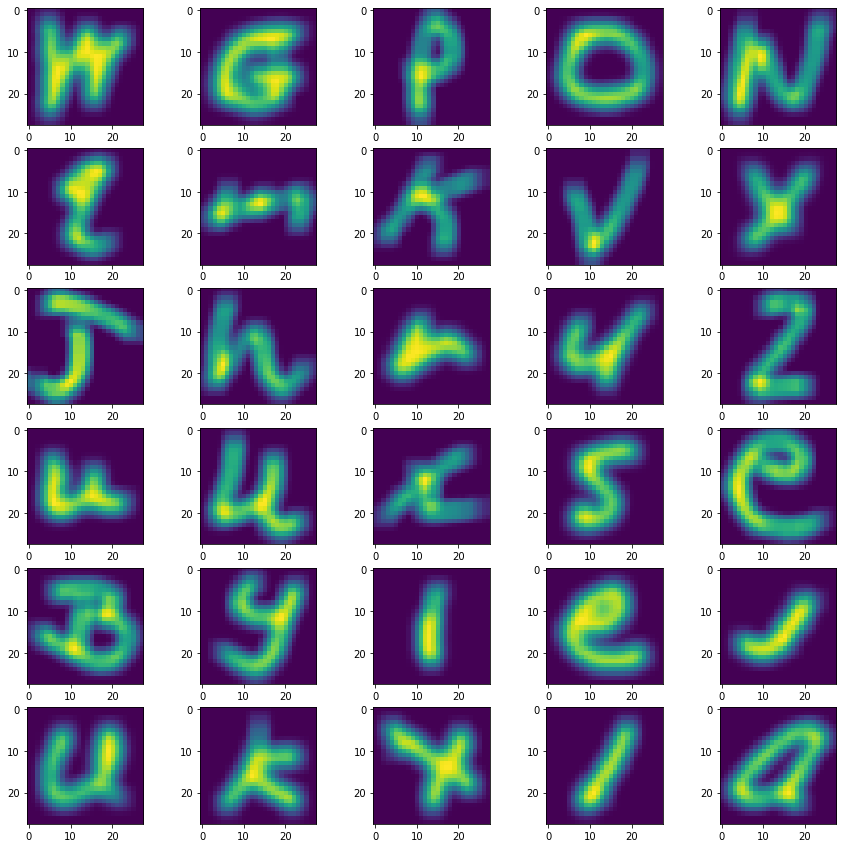

In [6]:
#print images after blurring with a kernel size of 5
f, axs = plt.subplots(6,5,figsize=(15,15))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.imshow(blurry_image_train_5[i])

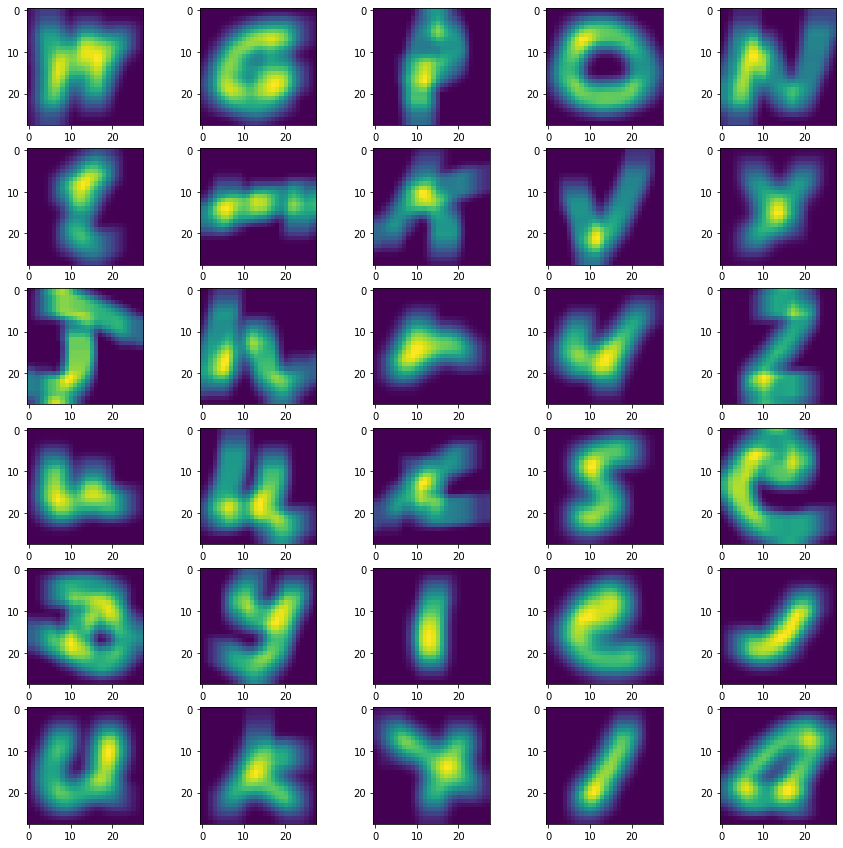

In [7]:
#print images after blurring with a kernel size of 7
f, axs = plt.subplots(6,5,figsize=(15,15))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.imshow(blurry_image_train_7[i])

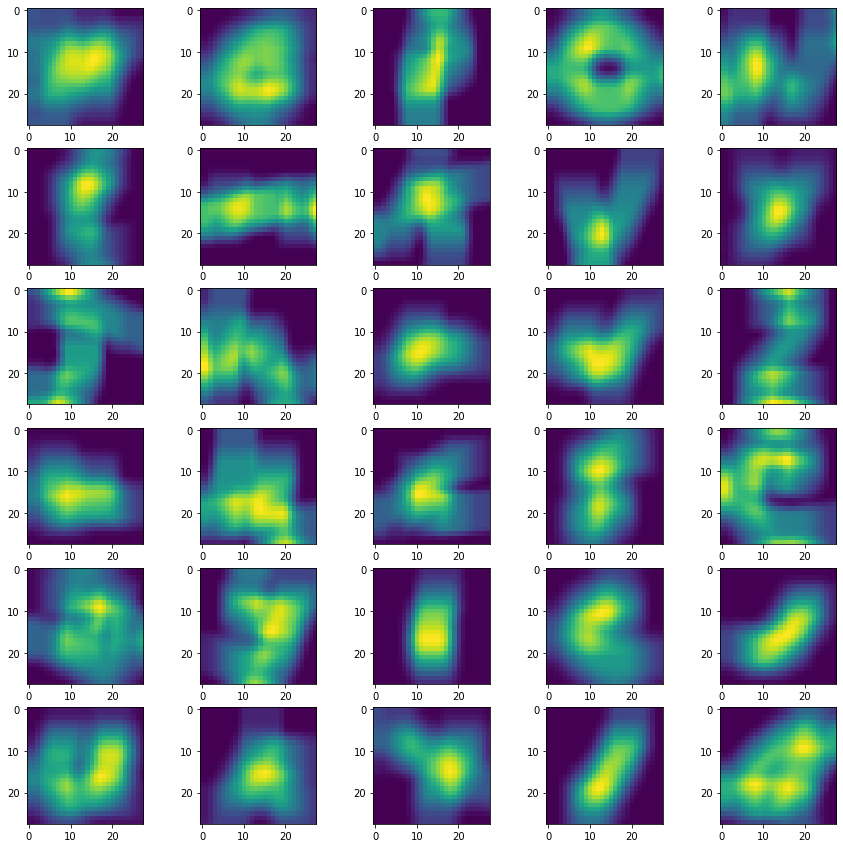

In [8]:
#print images after blurring with a kernel size of 10
f, axs = plt.subplots(6,5,figsize=(15,15))
for i in range(30):
  plt.subplot(6,5,i+1)
  plt.imshow(blurry_image_train_10[i])

In [9]:
#convert list to array so it can be reshaped
blurry_image_test_5 = np.array(blurry_image_test_5)
blurry_image_test_7 = np.array(blurry_image_test_7)
blurry_image_test_10 = np.array(blurry_image_test_10)

#reshape data for use in keras by adding 1 channel to normalize RGB color scheme
image_test = image_test.reshape(image_test.shape[0],28, 28,1)
blurry_image_test_5 =  blurry_image_test_5.reshape(blurry_image_test_5.shape[0],28, 28,1)
blurry_image_test_7 = blurry_image_test_7.reshape(blurry_image_test_7.shape[0],28, 28,1)
blurry_image_test_10 = blurry_image_test_10.reshape(blurry_image_test_10.shape[0],28, 28,1)

image_train = image_train.reshape(image_train.shape[0],28, 28,1)

#make sure all data is of type float
image_train = image_train.astype('float32')
image_test = image_test.astype('float32')
blurry_image_test_5 = blurry_image_test_5.astype('float32')
blurry_image_test_7 = blurry_image_test_7.astype('float32')
blurry_image_test_10 = blurry_image_test_10.astype('float32')


# Normalize RGB codes 
image_train /= 255
image_test /= 255

blurry_image_test_5 /= 255
blurry_image_test_7 /= 255
blurry_image_test_10 /= 255

#one hot encoding to get category names to numbers
print(label_train.shape)
label_train = tf.keras.utils.to_categorical(label_train)
label_test = tf.keras.utils.to_categorical(label_test)

print(label_train.shape)

(124800,)
(124800, 27)


## Creation of the Network

We based our simple model off of the VGG13 network architecture. The original VGG13 contains 13 layers. The VGG13 includes 5 blocks, each of which is repeated twice. The first block has 2 2D convolutional layers with 64 filters, and these convolutional layers are followed by a Max Pooling layer. Each subsequent block follows the same format, but the number of filters is doubled at the start of each block (the first block has 64 filters, the second block has 128 filters, and so on). Finally, the layers are flattened before 3 dense layers are added and an output is created. We based our simple model after the VGG13 architecture because VGG13 has been proven effective for large-scale image recognition.

For our example, we have simplified the VGG13 architecture to save processing time and computational resources. Our network contains only 4 blocks, and each block contains 2 2D convolutional layers that are followed by a Max pooling layer. Unlike VGG13, our first block begins with 32 filters and our final block contains 256 filters. The layers are then flattened before a dense layer of 256 units is added. Finally, a dense layer of 27 units is added so that the number of possible outputs equals the number of possible categories. The adam optimizer is used, and categorical crossentropy is used to calculate the loss for each epoch.



In [10]:
#create model - VGG 
model = keras.Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), padding='same',activation='relu'))
model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))


model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), padding='same',activation='relu'))
model.add(Conv2D(64, (3, 3), input_shape=(28, 28, 1), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(Conv2D(128, (3, 3), input_shape=(28, 28, 1), padding='same',activation='relu'))
model.add(Conv2D(128, (3, 3), input_shape=(28, 28, 1), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))


model.add(Conv2D(256, (3, 3), input_shape=(28, 28, 1), padding='same',activation='relu'))
model.add(Conv2D(256, (3, 3), input_shape=(28, 28, 1), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(27, activation='softmax'))
model.summary ()

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = model.fit(image_train, label_train, validation_data=(image_test, label_test), epochs=10, batch_size=32)
hist_5 = model.fit(image_train, label_train, validation_data=(blurry_image_test_5, label_test), epochs=10, batch_size=32)
hist_10 = model.fit(image_train, label_train, validation_data=(blurry_image_test_10, label_test), epochs=10, batch_size=32)
hist_7 = model.fit(image_train, label_train, validation_data=(blurry_image_test_7, label_test), epochs=10, batch_size=32)

#0.9353

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

## Analyzing the Results

To visualize the network's accuracy on images of varying levels of blurriness, we plot the loss and accuracy values for the original image dataset. We then compare this to the loss and accuracy values obtained when the network predicts the classes of blurry images. 

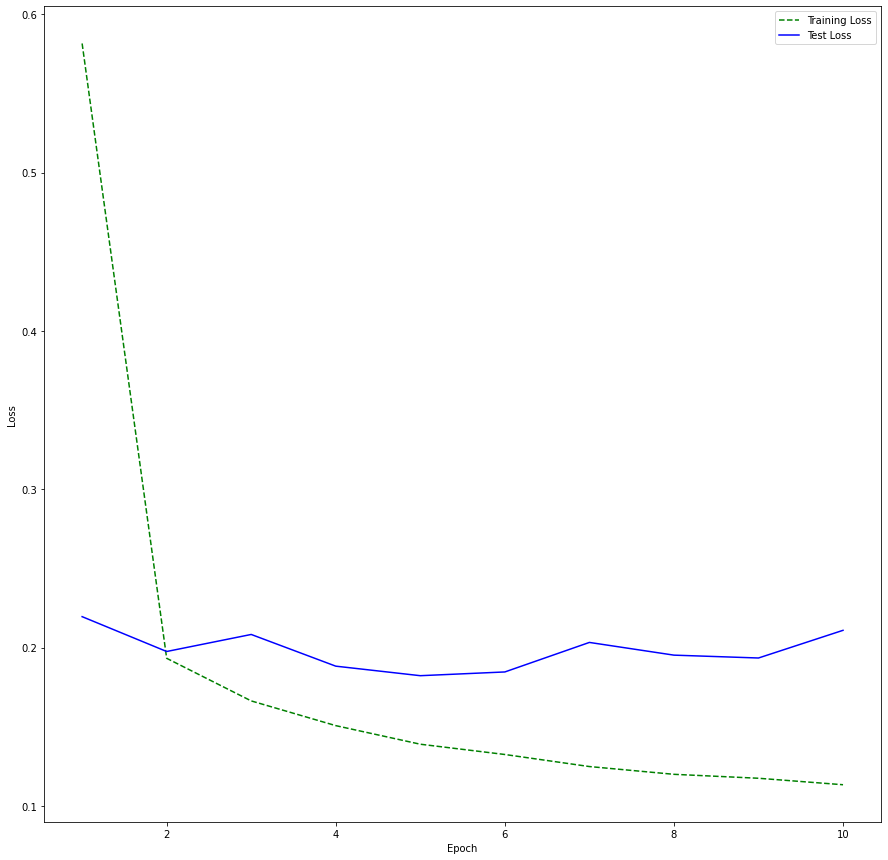

In [11]:
#training and test loss histories for the original dataset
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

training_acc = hist.history['accuracy']
test_acc = hist.history['val_accuracy']

#count the number of epochs
epoch_count = range(1, len(training_loss) + 1)

#loss graphs
plt.figure(figsize=(15,15))
plt.plot(epoch_count, training_loss, 'g--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



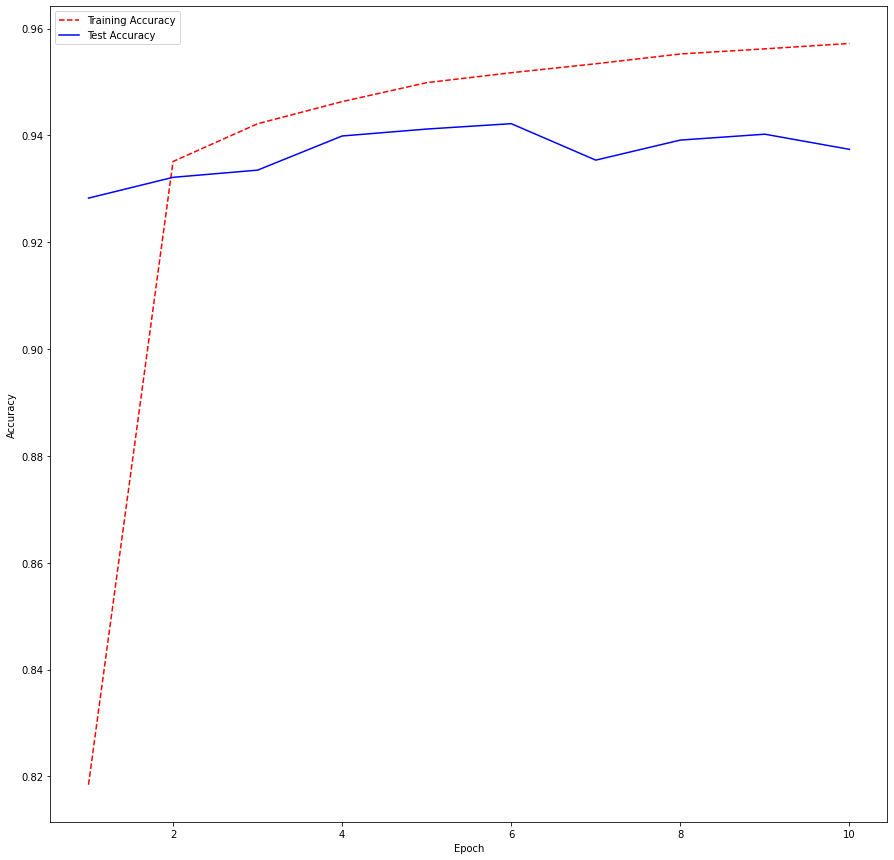

In [12]:
#accuracy graphs 
plt.figure(figsize=(15,15))
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, test_acc, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

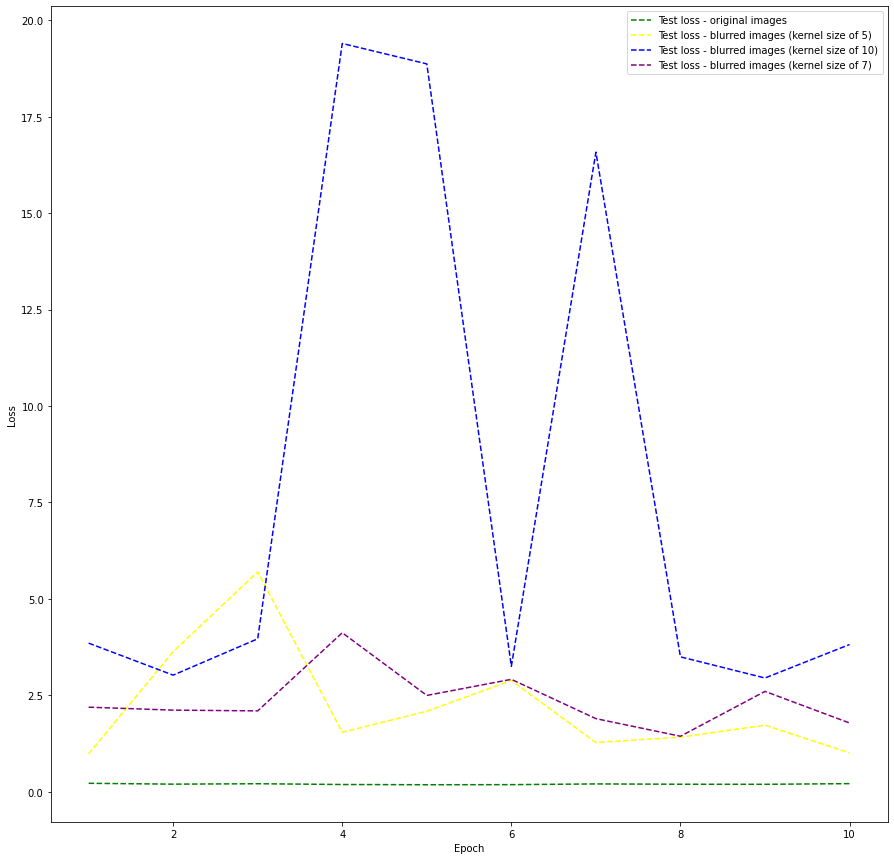

In [13]:
#training and test loss histories compared for all levels of blurriness
training_loss = hist.history['loss']
test_loss = hist.history['val_loss']

training_loss5 = hist_5.history['loss']
test_loss5 = hist_5.history['val_loss']

training_loss10 = hist_10.history['loss']
test_loss10 = hist_10.history['val_loss']

training_loss7 = hist_7.history['loss']
test_loss7 = hist_7.history['val_loss']

training_acc = hist.history['accuracy']
test_acc = hist.history['val_accuracy']

training_acc5 = hist_5.history['accuracy']
test_acc5 = hist_5.history['val_accuracy']

training_acc10 = hist_10.history['accuracy']
test_acc10 = hist_10.history['val_accuracy']

training_acc7 = hist_7.history['accuracy']
test_acc7 = hist_7.history['val_accuracy']

#count the number of epochs
epoch_count = range(1, len(test_loss) + 1)

#loss graphs 
plt.figure(figsize=(15,15))
plt.plot(epoch_count, test_loss, color = 'green', linestyle = 'dashed', label = 'Test loss - original images')
plt.plot(epoch_count, test_loss5, color = 'yellow', linestyle = 'dashed', label = 'Test loss - blurred images (kernel size of 5)')
plt.plot(epoch_count, test_loss7, color = 'purple', linestyle = 'dashed', label = 'Test loss - blurred images (kernel size of 7)')
plt.plot(epoch_count, test_loss10, color = 'blue', linestyle = 'dashed', label = 'Test loss - blurred images (kernel size of 10)')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()



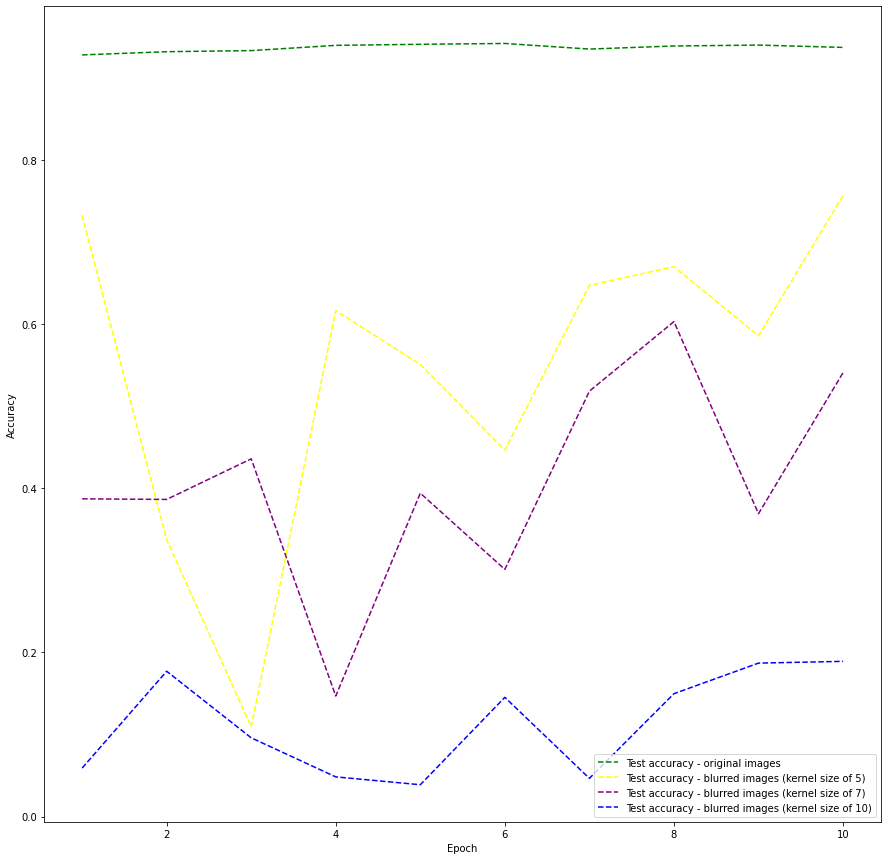

In [14]:
#accuracy graphs 
plt.figure(figsize=(15,15))
plt.plot(epoch_count, test_acc, color = 'green', linestyle = 'dashed', label = 'Test accuracy - original images')
plt.plot(epoch_count, test_acc5, color = 'yellow', linestyle = 'dashed', label = 'Test accuracy - blurred images (kernel size of 5)')
plt.plot(epoch_count, test_acc7, color = 'purple', linestyle = 'dashed', label = 'Test accuracy - blurred images (kernel size of 7)')
plt.plot(epoch_count, test_acc10, color = 'blue', linestyle = 'dashed', label = 'Test accuracy - blurred images (kernel size of 10)')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

As seen in our loss and accuracy graphs, blurring the image has a significant impact on network accuracy. The blurrier the image, the lower the network accuracy. The network reaches an accuracy of 94% on the original images, but only acheives 18% accuracy once the images are significantly blurred.
This is expected, as the visual representations of the images shows that blurry images are harder to classify, even for the human eye. 